### This notebook simulates raster scanning image correlation data (RICS)
Note that this simulation uses photon counting mode.
Click here to open in google colab: http://colab.research.google.com/github/jayunruh/pysimfcs/blob/main/sim_rics.ipynb

In [1]:
#if you are using this from google colab, you need the utility modules
#(everything else should already be installed)
import os
if(not os.path.exists('pysimfcs_utils.py')):
    print('downloading pysimfcs libraries')
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/pysimfcs_utils.py
if(not os.path.exists('analysis_utils.py')):
    !wget https://raw.githubusercontent.com/jayunruh/pysimfcs/refs/heads/main/analysis_utils.py
else:
    print('libraries already downloaded')

libraries already downloaded


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysimfcs_utils as simutils
import analysis_utils as autils
from tqdm.notebook import tqdm
import pandas as pd
import tifffile #added import to read and write tif files

In [3]:
#each species is described by number of particles, diffusion coefficient, and a brightness array (length 2?)
#simspecies=[{'N':200,'D':10.0,'B':[100000.0]}]
simspecies=[{'N':100,'D':10.0,'B':[100000.0,100000.0]},
           {'N':100,'D':10.0,'B':[100000.0,0.0]}]

In [4]:
#the simulation settings are boxsize (microns), boxpixels, w0 (2 sigma psf)
#zratio (z0/w0), nframes, frametime (us), background (array of cps), dims (active dimensions)
#mode--point, raster_line, raster_image, and image
simsettings={'boxsize':3.2,'boxpixels':64,'w0':0.17,'zratio':5,'nframes':32,
             'frametime':10.0,'background':[100.0,100.0],'dims':[True,True,True],
             'mode':'raster_image','boundarytype':'periodic','noisemode':'poisson'}

In [5]:
ssimsettings=simutils.scaleSimSettings(simsettings)
ssimspecies=simutils.scaleSimSpecies(simsettings,simspecies)

In [6]:
ssimsettings

{'boxsize': 3.2,
 'boxpixels': 64,
 'w0': 3.4,
 'zratio': 5,
 'nframes': 32,
 'frametime': 10.0,
 'background': [0.001, 0.001],
 'dims': [True, True, True],
 'mode': 'raster_image',
 'boundarytype': 'periodic',
 'noisemode': 'poisson'}

In [7]:
ssimspecies

[{'N': 100,
  'D': 0.03999999999999999,
  'B': [0.9999999999999999, 0.9999999999999999]},
 {'N': 100, 'D': 0.03999999999999999, 'B': [0.9999999999999999, 0.0]}]

In [8]:
simstack=simutils.runRasterSimulation(ssimsettings,ssimspecies)

  0%|          | 0/32 [00:00<?, ?it/s]

In [9]:
simstack.shape

(2, 32, 64, 64)

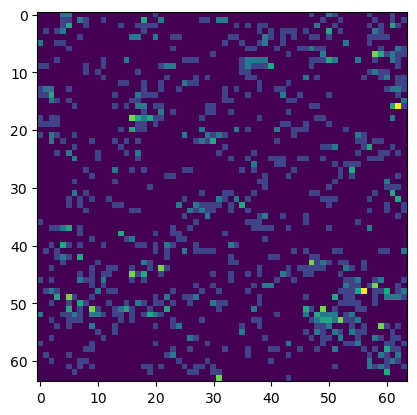

In [20]:
plt.imshow(simstack[0,0])

In [11]:
simstack.mean()

np.float64(0.21125411987304688)

In [12]:
vpsf=((np.pi/2.0)**1.5)*(simsettings['w0']**3)*simsettings['zratio']
vbox=simsettings['boxsize']**3
print('Vpsf',vpsf,'Vbox',vbox,'Vratio',vpsf/vbox)

Vpsf 0.04836114603958391 Vbox 32.76800000000001 Vratio 0.001475865052477536


In [13]:
tifffile.imwrite('simulation.tif',simstack.astype(float))

In [14]:
nchan=len(simspecies)
corrstack=[]
for i in range(nchan):
    corr=np.array([autils.autocorr2d(simimg) for simimg in simstack[i]]).mean(axis=0)
    corr=autils.avgquadrants(corr)
    midx,midy=corr.shape[1]//2,corr.shape[0]//2
    #set the middle pixel to the average from either side
    corr[midy,midx]=0.5*(corr[midy,midx+1]+corr[midy,midx-1])
    corrstack.append(corr)

In [15]:
ccorr=np.array([autils.crosscorr2d(simstack[0][i],simstack[1][i]) for i in range(len(simstack[0]))]).mean(axis=0)
ccorr=autils.avgquadrants(ccorr)
corrstack.append(ccorr)

Text(0.5, 1.0, 'crosscorr')

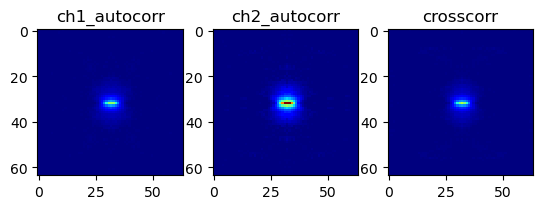

In [16]:
maxcorr=max([img.max() for img in corrstack])
ax=plt.subplot(1,3,1)
ax.imshow(corrstack[0],interpolation='none',vmin=0,vmax=maxcorr,cmap='jet')
ax.set_title('ch1_autocorr')
ax=plt.subplot(1,3,2)
ax.imshow(corrstack[1],interpolation='none',vmin=0,vmax=maxcorr,cmap='jet')
ax.set_title('ch2_autocorr')
ax=plt.subplot(1,3,3)
ax.imshow(corrstack[2],interpolation='none',vmin=0,vmax=maxcorr,cmap='jet')
ax.set_title('crosscorr')

Text(0, 0.5, 'G(pos)')

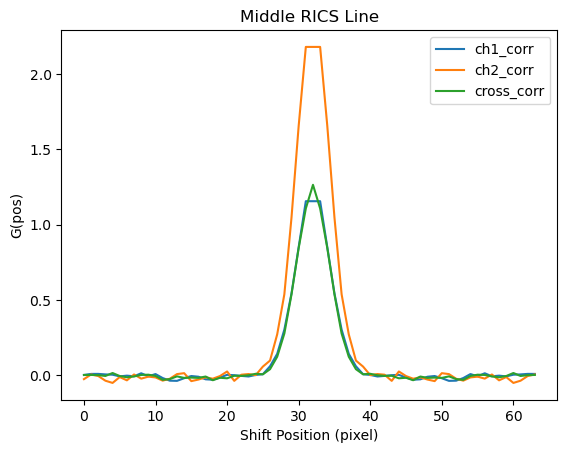

In [17]:
midpos=simsettings['boxpixels']//2
plt.plot(corrstack[0][midpos])
plt.plot(corrstack[1][midpos])
plt.plot(corrstack[2][midpos])
plt.title('Middle RICS Line')
plt.legend(['ch1_corr','ch2_corr','cross_corr'])
plt.xlabel('Shift Position (pixel)')
plt.ylabel('G(pos)')

In [18]:
tifffile.imwrite('corr.tif',corrstack)

Text(0, 0.5, 'G(pos)')

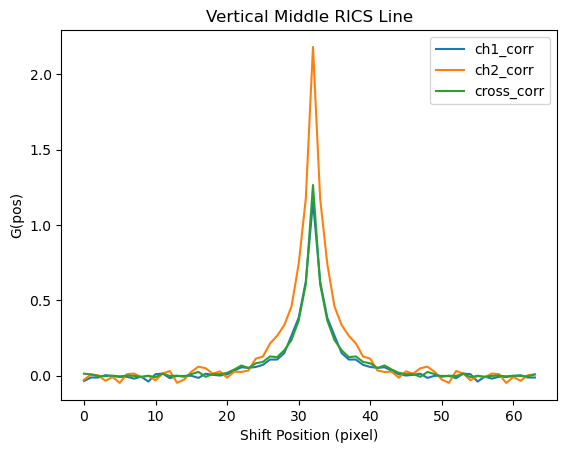

In [19]:
plt.plot(corrstack[0][:,midpos])
plt.plot(corrstack[1][:,midpos])
plt.plot(corrstack[2][:,midpos])
plt.title('Vertical Middle RICS Line')
plt.legend(['ch1_corr','ch2_corr','cross_corr'])
plt.xlabel('Shift Position (pixel)')
plt.ylabel('G(pos)')